# Iteration 1

## Connecting Colabs to BigQuery project

In [ ]:
#  Install Required Packages in Colab
!pip install --upgrade google-cloud-bigquery

In [ ]:
# Authenticate with Google Account
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cinemaparadiso-462409-f2ba92221c1f.json to cinemaparadiso-462409-f2ba92221c1f.json


In [ ]:
from google.oauth2 import service_account
from google.cloud import bigquery

key_path = "cinemaparadiso-462409-f2ba92221c1f.json"

credentials = service_account.Credentials.from_service_account_file(key_path)

project_id = "cinemaparadiso-462409"

client = bigquery.Client(credentials=credentials, project=project_id)
client = bigquery.Client(project="cinemaparadiso-462409")

In [ ]:
import pandas as pd

In [ ]:
# Read table cleaned_imdb_movies
query = "SELECT * FROM `cinemaparadiso-462409.cinema_paradiso.fa_general_cinema_bfi_netflix_merged`"
df_general_cinema_bfi_netflix = client.query(query).to_dataframe()

# Read table cleaned_imdb_movies
query = "SELECT * FROM `cinemaparadiso-462409.cinema_paradiso.fa_list_statistics_imdb_merged_bygenre`"
df_movie_scores = client.query(query).to_dataframe()

# Read table cleaned_imdb_movies
query = "SELECT * FROM `cinemaparadiso-462409.cinema_paradiso.ba_general_cinema_bfi_netflic_merged_without_filtering`"
df_general_cinema_bfi_netflix_no_filter = client.query(query).to_dataframe()

## UpSet Plot

In [ ]:
# Libraries to create Venn diagrams and UpSet plots:
!pip install matplotlib-venn
!pip install upsetplot

In [ ]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/

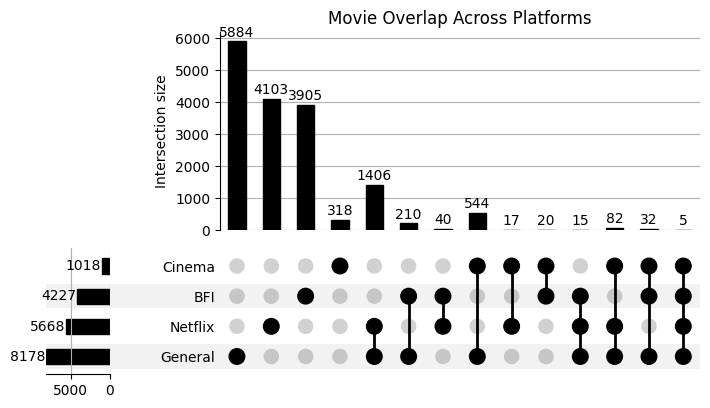

In [ ]:
# UpSet PLOT TO REPRESENT OVERLAPPING AND UNIQUE CONTENT:

# Create a membership list per row
df_general_cinema_bfi_netflix['set'] = df_general_cinema_bfi_netflix.apply(
    lambda row: [source for source in ['General', 'Cinema', 'Netflix', 'BFI'] if row[f'in_{source.lower()}'] == 1],
    axis=1
)

# Generate UpSet data from the list of source memberships
upset_data = from_memberships(df_general_cinema_bfi_netflix['set'])

# Create the plot
UpSet(upset_data, subset_size='count', show_counts=True).plot()
plt.title("Movie Overlap Across Platforms")
plt.show()


## Venn diagram

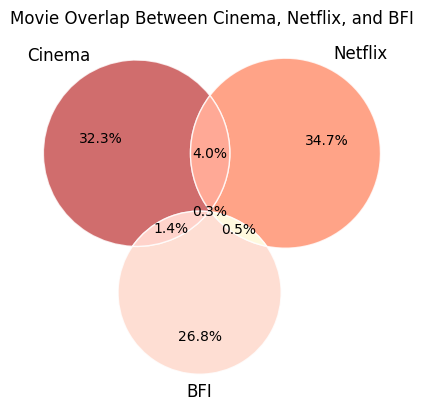

In [ ]:
# VEN DIAGRAM TO COMPARE ONLY CINEMA, NETFLIX AND BFI


from matplotlib_venn import venn3

# Define each group
cinema_set = set(df_general_cinema_bfi_netflix_no_filter[df_general_cinema_bfi_netflix_no_filter['in_cinema'] == 1]['title'])
netflix_set = set(df_general_cinema_bfi_netflix_no_filter[df_general_cinema_bfi_netflix_no_filter['in_netflix'] == 1]['title'])
bfi_set    = set(df_general_cinema_bfi_netflix_no_filter[df_general_cinema_bfi_netflix_no_filter['in_bfi'] == 1]['title'])

# Total number of unique titles across all sets
total = len(cinema_set | netflix_set | bfi_set)

# Plot Venn
venn = venn3([cinema_set, netflix_set, bfi_set],
        set_labels=('Cinema', 'Netflix', 'BFI'),
        subset_label_formatter=lambda x: f"{x / total:.1%}" if x else '',
        set_colors=('#c54848','#ff8c69' ,'#fed6c9')  # Cinema, Netflix, BFI
)

# Improve visual clarity
for patch in venn.patches:
    if patch:
        patch.set_alpha(0.8)
        patch.set_edgecolor('white')

plt.title("Movie Overlap Between Cinema, Netflix, and BFI")
plt.show()

In [ ]:
# I want to create a bar chart where I show for each genre, how many times it is present in each of the platforms.
# Check the columns
df_general_cinema_bfi_netflix.columns

Index(['title', 'year', 'score_general', 'score_cinema', 'score_netflix',
       'score_bfi', 'action', 'adventure', 'animation', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'history', 'horror',
       'music', 'mystery', 'romance', 'scifi', 'tv_movie', 'thriller', 'war',
       'western', 'biography', 'film_noir', 'in_general', 'in_cinema',
       'in_netflix', 'in_bfi', 'source_count', 'set'],
      dtype='object')

In [ ]:
# BAR CHART TABLE (number of movies per genre, per platform)

# create a list with the genres
genres = [
    'action', 'adventure', 'animation', 'comedy', 'crime',
    'documentary', 'drama', 'family', 'fantasy', 'history', 'horror',
    'music', 'mystery', 'romance', 'scifi', 'tv_movie', 'thriller',
    'war', 'western', 'biography', 'film_noir'
]

# create a dictionary with the platforms
platforms = {
    'in_cinema': 'Cinema',
    'in_netflix': 'Netflix',
    'in_bfi': 'BFI',
    'in_general': 'General'
}

# Create a list to collect the rows
list = []

# Loop over each genre and inside each loop, inside every platform
for genre in genres:
    for platform_column, platform_name in platforms.items():
        # Filter the DataFrame to movies with this genre AND on this platform
        filtered = df_general_cinema_bfi_netflix_no_filter[(df_general_cinema_bfi_netflix_no_filter[genre] == 1) & (df_general_cinema_bfi_netflix_no_filter[platform_column] == 1)]
        count = len(filtered)

        # Store the result
        list.append({'genre': genre, 'platform': platform_name, 'movie_count': count})

# Convert the result to a DataFrame
fa_general_cinema_netflix_bfi_pergenre_without_filtering = pd.DataFrame(list)

# create a csv file
csv_filename = 'fa_general_cinema_netflix_bfi_pergenre_without_filtering.csv'
fa_general_cinema_netflix_bfi_pergenre_without_filtering.to_csv(csv_filename, index=False)


## Data Organisation

In [ ]:
# HEATMAP TABLE (average score per genre, per platform)

# Step 1: Build the long-form DataFrame with avg_score by genre & platform
results = []

genre_hm = [
    'action', 'adventure', 'animation', 'comedy', 'crime',
    'documentary', 'drama', 'family', 'fantasy', 'history', 'horror',
    'music', 'mystery', 'romance', 'scifi', 'tv_movie', 'thriller',
    'war', 'western', 'biography', 'film_noir'
]

# Loop through each genre and platform, calculate avg_score
for genre in genre_hm:
    for plat in ['in_cinema', 'in_netflix', 'in_bfi']:
        mask = (df_general_cinema_bfi_netflix[genre] == 1) & (df_general_cinema_bfi_netflix[plat] == 1)
        avg = df_general_cinema_bfi_netflix.loc[mask, 'score_general'].mean()
        results.append({
            'genre': genre,
            'platform': plat.replace('in_', '').capitalize(),  # e.g. "Cinema"
            'avg_score': avg
        })

# Convert to DataFrame
fa_heatmap_long = pd.DataFrame(results)

# Step 2: Pivot to wide format: genres as rows, platforms as columns
fa_heatmap_wide = fa_heatmap_long.pivot(index='genre', columns='platform', values='avg_score')

# Step 3: Sort by Cinema column (descending)
fa_heatmap_sorted = fa_heatmap_wide.sort_values(by='Cinema', ascending=False).reset_index()

# Step 4: Export to CSV
csv_filename = 'fa_heatmap_sorted_by_cinema.csv'
fa_heatmap_sorted.to_csv(csv_filename, index=False)


In [ ]:
fa_heatmap_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   genre    21 non-null     object 
 1   Bfi      18 non-null     float64
 2   Cinema   20 non-null     float64
 3   Netflix  19 non-null     float64
dtypes: float64(3), object(1)
memory usage: 804.0+ bytes
